# Bitcoin Prediction

In this notebook we will try to predict the price of bitcoin.

To do this, we will create a recurrent neural network with LSTM layers.
We will compare the results with those obtained using classical forecasting methods such as fbProphet.

In [10]:
import pandas as pd
import pandas_datareader as pdr
import datetime
import numpy as np

#keras
import keras
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator

#sklearn
from sklearn.preprocessing import MinMaxScaler

#display
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
pd.options.plotting.backend = "plotly"
import matplotlib.pyplot as plt
sns.set_theme()

#statsmodels
from statsmodels.tsa.arima.model import ARIMA

We retrieve bitcoin closing prices since September 2014 using the yahoo API.

In [48]:
import pandas_datareader as pdr
import datetime
btc_data = pdr.get_data_yahoo(['BTC-USD'], 
                          start=datetime.datetime(2014, 9, 16), 
                          end=datetime.datetime(2021, 4, 2))
btc_data.columns = btc_data.columns.droplevel(1)
btc_data.head()

Attributes,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2014-09-16,457.334015,457.334015,468.174011,452.421997,465.864014,21056800.0
2014-09-17,424.440002,424.440002,456.859985,413.104004,456.859985,34483200.0
2014-09-18,394.795990,394.795990,427.834991,384.532013,424.102997,37919700.0
2014-09-19,408.903992,408.903992,423.295990,389.882996,394.673004,36863600.0
2014-09-20,398.821014,398.821014,412.425995,393.181000,408.084991,26580100.0


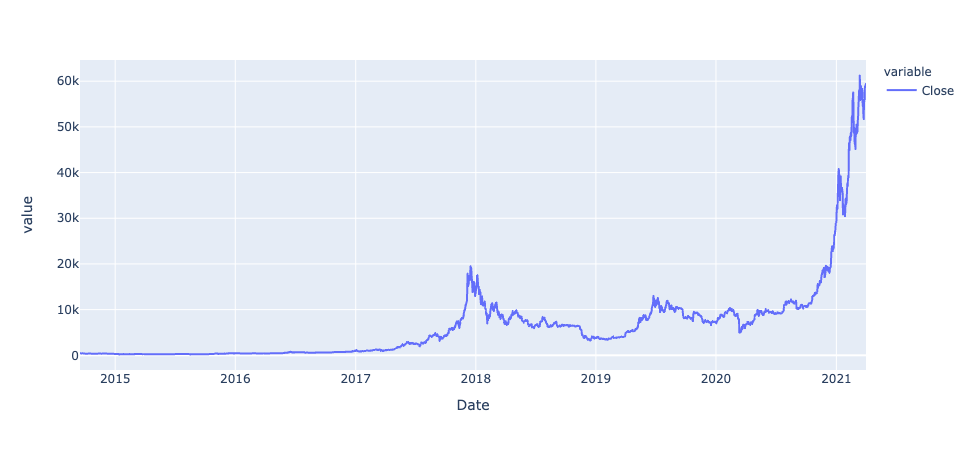

In [49]:
btc_data['Close'].plot()

## Extract data

We focus for now on the closing price of BTC-USD.

In [54]:
# split data
PREDICTIONS_DAYS = 700
N_FEATURES = 1
WINDOW_SIZE = 365
BATCH_SIZE = 8

# split data frames into train and test
df_train = btc_data.iloc[:len(btc_data)-PREDICTIONS_DAYS]['Close']
df_val = btc_data.iloc[len(btc_data)-PREDICTIONS_DAYS:]['Close']
df_test = btc_data.iloc[len(btc_data)-PREDICTIONS_DAYS-WINDOW_SIZE:]

# values
train_values = df_train.values
val_values = df_val.values
test_values = df_test.values
all_values = btc_data.values

series_train= np.reshape(train_values, (len(train_values), N_FEATURES))
series_val = np.reshape(val_values, (len(val_values), N_FEATURES))
series_test = np.reshape(test_values, (len(test_values), N_FEATURES))
series = np.reshape(all_values, (len(all_values), N_FEATURES))
print(series_train.shape, series_val.shape, series_test.shape)

sc = MinMaxScaler()
series_train = sc.fit_transform(series_train)
series_val = sc.transform(series_val)
series_test = sc.transform(series_test)

# define generator
train_generator = TimeseriesGenerator(series_train, series_train, length=WINDOW_SIZE, batch_size=BATCH_SIZE)
val_generator = TimeseriesGenerator(series_val, series_val, length=WINDOW_SIZE, batch_size=BATCH_SIZE)
test_generator = TimeseriesGenerator(series_test, series_test, length=WINDOW_SIZE, batch_size=BATCH_SIZE)

ValueError: cannot reshape array of size 10116 into shape (1686,1)

## Training

In [ ]:
def build_model():
    # Initialising the RNN
    model = Sequential()

    # Adding the input layer and the LSTM layer
    model.add(LSTM(units = 200, input_shape = (WINDOW_SIZE, 1), return_sequences=True))
    
    #Dropout to avoid overfiting
    model.add(Dropout(0.25))
    
    # Adding a second LSTM layer
    model.add(LSTM(units = 100))
    
    #Dropout to avoid overfiting
    model.add(Dropout(0.25))
    
    # Adding the output layer
    model.add(Dense(units = 1, activation = "linear"))

    # Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'MSE', metrics=["mae"])

    # Fitting the RNN to the Training set
    model.summary()

    return model

In [32]:
model = build_model()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 365, 200)          161600    
_________________________________________________________________
dropout_4 (Dropout)          (None, 365, 200)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 282,101
Trainable params: 282,101
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = model.fit(train_generator, validation_data = val_generator, epochs = 10)

Epoch 1/10
166/166 [==============================] - 41s 233ms/step - loss: 0.0047 - mae: 0.0478 - val_loss: 0.0891 - val_mae: 0.1833
Epoch 2/10
166/166 [==============================] - 39s 234ms/step - loss: 0.0019 - mae: 0.0295 - val_loss: 0.0627 - val_mae: 0.1436
Epoch 3/10
166/166 [==============================] - 38s 229ms/step - loss: 0.0012 - mae: 0.0225 - val_loss: 0.0311 - val_mae: 0.0986
Epoch 4/10
166/166 [==============================] - 38s 231ms/step - loss: 0.0066 - mae: 0.0484 - val_loss: 0.0775 - val_mae: 0.1660
Epoch 5/10
166/166 [==============================] - 38s 229ms/step - loss: 0.0031 - mae: 0.0366 - val_loss: 0.0217 - val_mae: 0.0814
Epoch 6/10
166/166 [==============================] - 47s 281ms/step - loss: 9.9843e-04 - mae: 0.0184 - val_loss: 0.0434 - val_mae: 0.1215
Epoch 7/10
166/166 [==============================] - 41s 249ms/step - loss: 0.0013 - mae: 0.0206 - val_loss: 0.1147 - val_mae: 0.2014
Epoch 8/10
166/166 [==============================]

In [34]:
def plot_training_analysis(history, metric='loss'):    

  loss = history.history[metric]
  val_loss = history.history['val_' + metric]

  epochs = range(len(loss))

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training ' + metric)
  plt.plot(epochs, val_loss, 'g', label='Validation ' + metric)
  plt.title('Training and validation ' + metric)
  plt.legend()
  plt.yscale("log")
  plt.show()

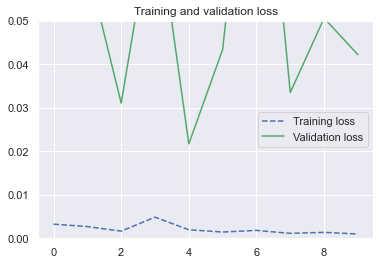

In [35]:
plot_training_analysis(history)

In [36]:
def join_df(train_datetime, train_values, test_datetime, test_values):
    test_values = np.reshape(test_values, (len(test_values)))
    datetime = np.append(train_datetime, test_datetime, axis=0)
    values = np.append(train_values, test_values, axis=0)
    label_train = ['train' for x in train_values]
    label_test = ['test' for x in test_values]
    label = np.append(label_train, label_test, axis=0)
    df_pred = pd.DataFrame(data = np.transpose([datetime, label, values]), columns = ["datetime", "label", "value"])
    df_pred['datetime'] = pd.to_datetime(df_pred['datetime'])
    df_pred.set_index('datetime', inplace=True)
    df_pred = df_pred.astype({"value" : "float32"})
    return df_pred

In [37]:
y_test_pred = sc.inverse_transform(model.predict(test_generator))
print(y_test_pred.shape)
df_pred = join_df(df_train.index, df_train.values, df_val.index, y_test_pred)
df_pred.head()

(700, 1)


,label,value
datetime,,
2014-09-16,train,457.334015
2014-09-17,train,424.440002
2014-09-18,train,394.795990
2014-09-19,train,408.903992
2014-09-20,train,398.821014


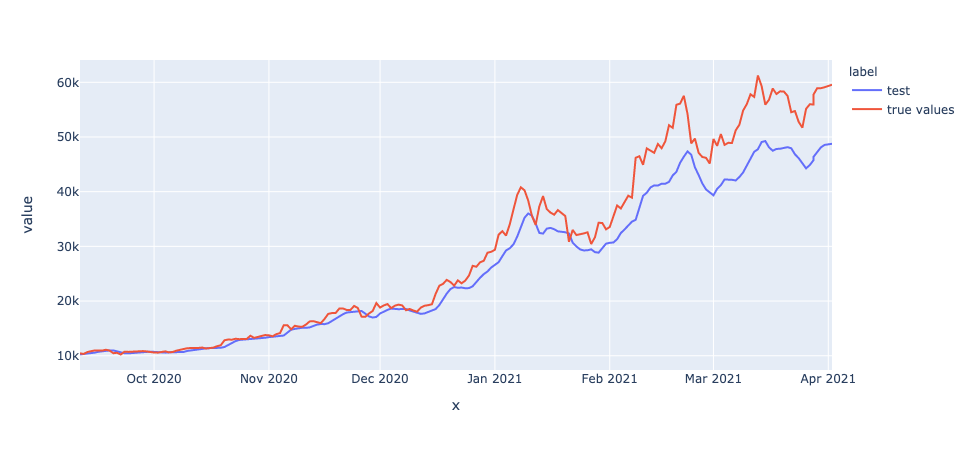

In [55]:
num_val = 200
fig = px.line(df_pred[-num_val:], x = df_pred.index[-num_val:], y = "value", color="label")
fig.add_trace(go.Scatter(x = df_test.index[-num_val:], y = df_test.values[-num_val:], name = "true values"))
fig.show()

## Forecasting avec ensemble de test

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 365, 200)          161600    
_________________________________________________________________
dropout_10 (Dropout)         (None, 365, 200)          0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 100)               120400    
_________________________________________________________________
dropout_11 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 282,101
Trainable params: 282,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
166/166 [==============================] - 39s 218ms/step - loss: 0.0073 - mae: 0.0585
Epoch 2/5
166/166

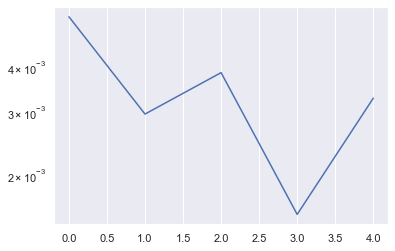

In [75]:
sc = MinMaxScaler()
series_forecasting = sc.fit_transform(train_values.reshape(-1, 1))
generator_forecasting = TimeseriesGenerator(series_forecasting, series_forecasting, 
                                            length=WINDOW_SIZE, batch_size=8)
# fit model
model = build_model()
history = model.fit(generator_forecasting, epochs=5, verbose=1)
plt.plot(history.history["loss"])
plt.yscale('log')
plt.show()

In [83]:
def forecast_lstm(series_forecasting, nb_val):
    predictions = list()
    series_f = series_forecasting.copy()
    for i in range(nb_val):
        prediction = model.predict(np.expand_dims(series_f[-WINDOW_SIZE:], axis=0))
        yhat = prediction[-1]
        #print(sc.inverse_transform([yhat])[0][0])
        #Append forecasted value
        predictions.append(yhat)
        series_f = np.append(series_f, [yhat], axis=0)
    
    return predictions

In [84]:
# datetimes of train and test dataset
datetimes = df_train.index
dt_forecast = pd.date_range(start = datetimes[-1]+ datetime.timedelta(days=1), end=datetime.datetime(2021, 5, 8))

# Number of value to forecast
NB_VAL = len(dt_forecast)

# compute predictions
predictions_lstm = forecast_lstm(series_forecasting, NB_VAL)

# inverse transformation of MinMaxScaler
predictions_lstm = sc.inverse_transform(predictions_lstm)

# join train df and test predicted df
df_forecast_lstm = join_df(df_train.index, df_train.values, dt_forecast, predictions_lstm)
df_forecast_lstm.tail(5)

,label,value
datetime,,
2021-05-04,test,21410.414062
2021-05-05,test,21410.410156
2021-05-06,test,21410.414062
2021-05-07,test,21410.414062
2021-05-08,test,21410.414062


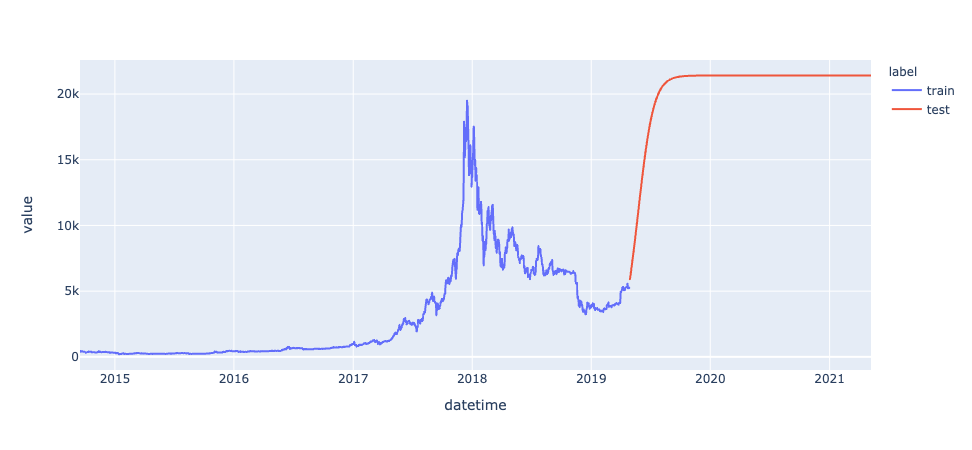

In [85]:
fig = px.line(df_forecast_lstm, x=df_forecast_lstm.index, y="value", color="label")
fig.show()

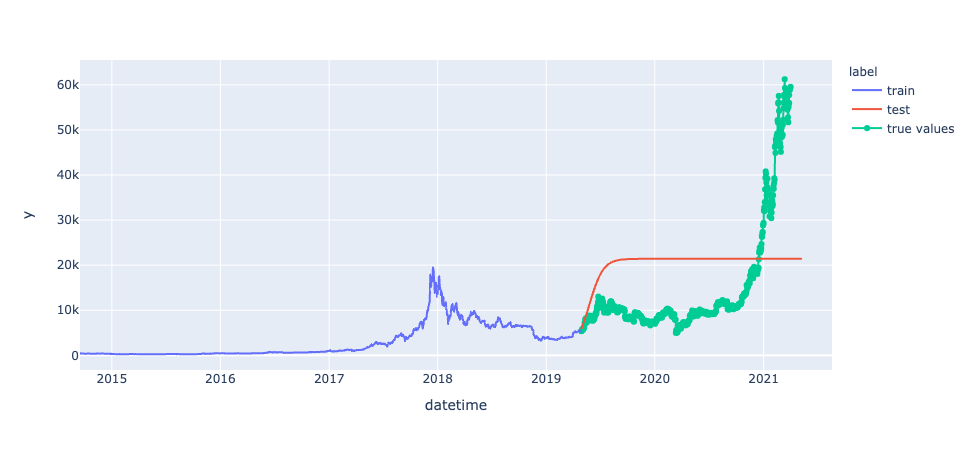

In [86]:
date=df_forecast_lstm.index

# Create traces
fig = px.line(df_forecast_lstm,x=df_forecast_lstm.index, y=df_forecast_lstm.value.values, color='label')
fig.add_trace(go.Scatter(x=df_val.index, y=df_val.values,
                    mode='lines+markers', name= "true values"))

fig.show()

## Forecasting sans ensemble de test

In [5]:
sc = MinMaxScaler()
series_forecasting = sc.fit_transform(all_values.reshape(-1, 1))
generator_forecasting = TimeseriesGenerator(series_forecasting, series_forecasting, 
                                            length=WINDOW_SIZE, batch_size=8)
# fit model
model = build_model()
history = model.fit(generator_forecasting, epochs=5, verbose=1)
plt.plot(history.history["loss"])
plt.yscale('log')
plt.show()

NameError: name 'all_values' is not defined

In [89]:
# datetimes of train and test dataset
datetimes = df_train.index
dt_forecast = pd.date_range(start = datetimes[-1]+ datetime.timedelta(days=1), end=datetime.datetime(2021, 5, 8))

# Number of value to forecast
NB_VAL = len(dt_forecast)

# compute predictions
predictions_lstm = forecast_lstm(series_forecasting, NB_VAL)

# inverse transformation of MinMaxScaler
predictions_lstm = sc.inverse_transform(predictions_lstm)

# join train df and test predicted df
df_forecast_lstm = join_df(btc_data.index, btc_data.values, dt_forecast, predictions_lstm)
df_forecast_lstm.tail(5)

,label,value
datetime,,
2021-05-04,test,15149.077148
2021-05-05,test,15148.824219
2021-05-06,test,15148.576172
2021-05-07,test,15148.327148
2021-05-08,test,15148.084961


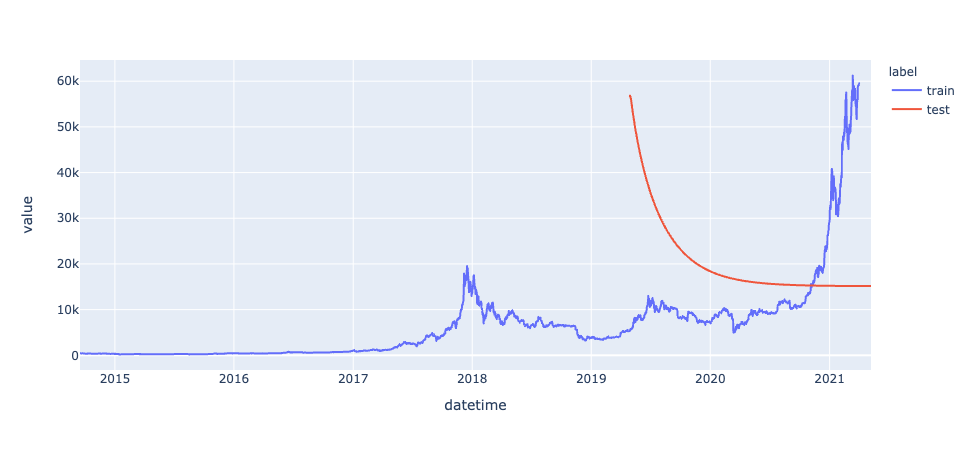

In [90]:
fig = px.line(df_forecast_lstm, x=df_forecast_lstm.index, y="value", color="label")
fig.show()

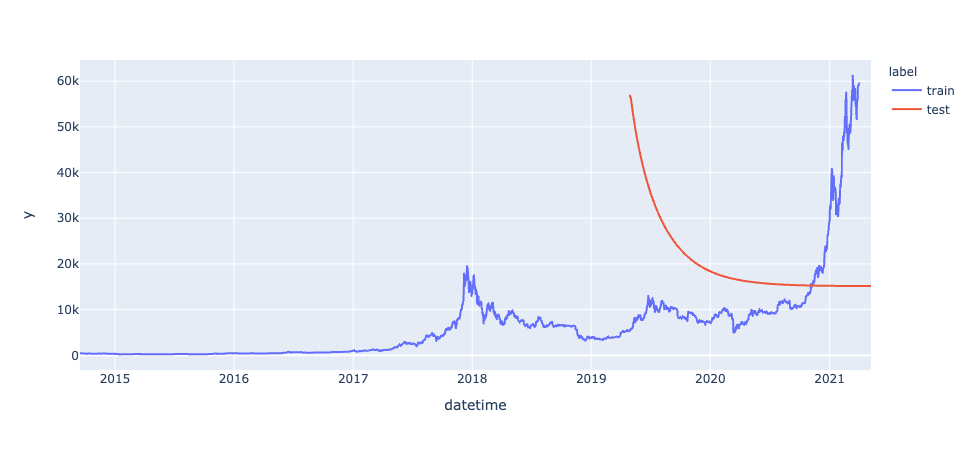

In [91]:
date=df_forecast_lstm.index

# Create traces
fig = px.line(df_forecast_lstm,x=df_forecast_lstm.index, y=df_forecast_lstm.value.values, color='label')

fig.show()

## Prophet

In [92]:
### Prophet
from fbprophet import Prophet

columns = ["ds", "y"]
df_prophet = pd.DataFrame(columns = columns)
df_prophet["ds"] = btc_data.index
df_prophet["y"] = btc_data.values

sc = MinMaxScaler()
df_prophet["y"] = sc.fit_transform(np.reshape(df_prophet.y.values, (-1, 1)))
df_prophet.head()

ModuleNotFoundError: No module named 'fbprophet'

In [ ]:
m = Prophet()
m.fit(df_prophet)

In [ ]:
# Python
future = m.make_future_dataframe(freq='s', periods=NB_VAL, include_history=True)
future.tail()

In [ ]:
# Python
forecast_prophet = m.predict(future)
forecast_prophet.tail()

In [ ]:
fig1 = m.plot(forecast_prophet)